In [717]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

users = pd.read_csv('takehome_users.csv', encoding = 'latin-1')
users.index = users['object_id']
user_daily = pd.read_csv('takehome_user_engagement.csv')

In [718]:
users['creation_time'] = pd.to_datetime(users['creation_time'], format = "%Y-%m-%d %H:%M:%S")
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [719]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,,
1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
3,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
4,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
5,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [720]:
users.shape

(12000, 10)

In [721]:
users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool

In [722]:
users.loc[users['invited_by_user_id'].isnull()].shape

(5583, 10)

We can assume that 5583 users joined directly without an invitation.  We'll fill those null values with the string 'N/A'.

In [723]:
users['invited_by_user_id'].fillna('N/A', inplace = True)

In [724]:
users.loc[users['last_session_creation_time'].isnull()].shape

(3177, 10)

In [725]:
# create column containing total number of logins in user dataframe
users['no_of_logins'] = user_daily.groupby('user_id').count()['time_stamp']
users['no_of_logins'].fillna(0, inplace = True)

# select users who have a NaN value in 'last_session_creation_time' and see how many logins they have
users.loc[users['last_session_creation_time'].isnull()]['no_of_logins'].value_counts()

0.0    3177
Name: no_of_logins, dtype: int64

All 3177 users with null values in 'last_session_creation_time' never actually logged in.  They only signed up.  We'll set their last session time to the creation time.

In [726]:
users['last_session_creation_time'].fillna(users['creation_time'], inplace = True)

In [727]:
users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id            False
no_of_logins                  False
dtype: bool

The data is clean, we may continue.

In [728]:
user_daily.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [729]:
user_daily.isnull().any()

time_stamp    False
user_id       False
visited       False
dtype: bool

In [730]:
# create a column indicating the length of time between the second previous login for each user
# if there is no second previous login, it will be NaN
user_daily['time_stamp'] = pd.to_datetime(user_daily['time_stamp'], format = "%Y-%m-%d %H:%M:%S")
user_daily['second_prev_login'] = user_daily.groupby('user_id')['time_stamp'].diff(periods = 2).dt.days
user_daily.head(10)

,time_stamp,user_id,visited,second_prev_login
0,2014-04-22 03:53:30,1,1,NaN
1,2013-11-15 03:45:04,2,1,NaN
2,2013-11-29 03:45:04,2,1,NaN
3,2013-12-09 03:45:04,2,1,24.0
4,2013-12-25 03:45:04,2,1,26.0
5,2013-12-31 03:45:04,2,1,22.0
6,2014-01-08 03:45:04,2,1,14.0
7,2014-02-03 03:45:04,2,1,34.0
8,2014-02-08 03:45:04,2,1,31.0
9,2014-02-09 03:45:04,2,1,6.0


In [731]:
# create list of users who have at least one instance of three logins within a 7 day rolling period
ids = user_daily.loc[user_daily['second_prev_login'] <= 7]['user_id'].unique()
print("{}".format(len(ids)) + ' users logged in at least 3 times within a single 7 day rolling period.')

1656 users logged in at least 3 times within a single 7 day rolling period.


In [732]:
# add boolean column indicating whether the user has "adopted"
users['adopted'] = np.where(users['object_id'].isin(ids), 1, 0)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,no_of_logins,adopted
object_id,,,,,,,,,,,,
1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1.0,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14.0,1
3,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1.0,0
4,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1.0,0
5,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1.0,0


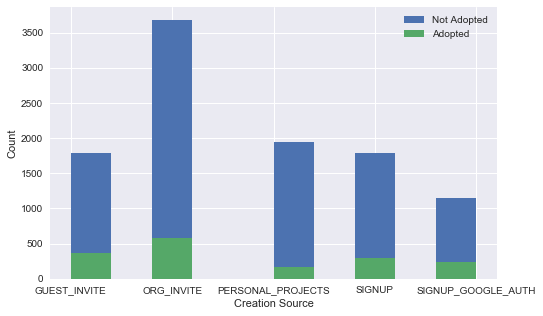

In [733]:
fig, ax = plt.subplots(figsize = (8,5))
users.groupby('adopted')['creation_source'].hist()
ax.set_xlabel('Creation Source')
ax.set_ylabel('Count')
plt.legend(['Not Adopted','Adopted'])
plt.show()

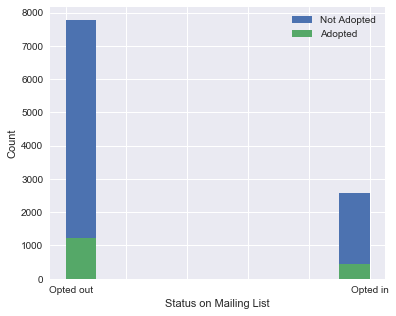

In [734]:
fig, ax = plt.subplots(figsize = (6,5))
users.groupby('adopted')['opted_in_to_mailing_list'].hist()
ax.set_xlabel('Status on Mailing List')
ax.set_ylabel('Count')
ax.set_xticklabels(['','    Opted out',' ',' ',' ',' ','Opted in'])
plt.legend(['Not Adopted','Adopted'])
plt.show()

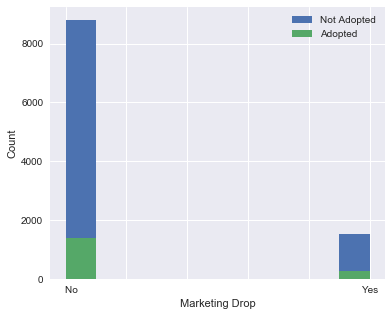

In [735]:
fig, ax = plt.subplots(figsize = (6,5))
users.groupby('adopted')['enabled_for_marketing_drip'].hist()
ax.set_xlabel('Marketing Drop')
ax.set_ylabel('Count')
ax.set_xticklabels(['','    No',' ',' ',' ',' ','Yes'])
plt.legend(['Not Adopted','Adopted'])
plt.show()

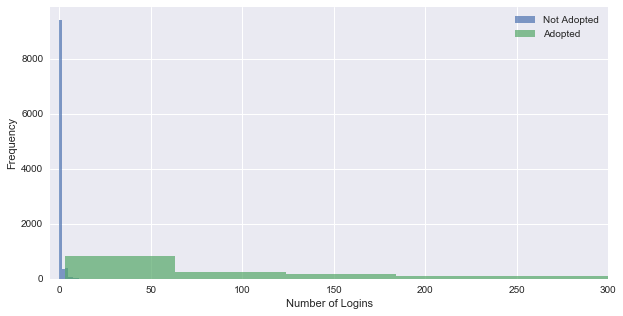

In [736]:
fig, ax = plt.subplots(figsize = (10,5))
users.groupby('adopted')['no_of_logins'].hist(alpha = .7)
ax.set_xlabel('Number of Logins')
ax.set_ylabel('Frequency')
ax.set_xlim(-5,300)
plt.legend(['Not Adopted','Adopted'])
plt.show()

In [737]:
users['time_diff'] = users['last_session_creation_time'] - users['creation_time']
users['time_diff'] = users['time_diff'].dt.days
users['signup_year'] = users['creation_time'].dt.year
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,no_of_logins,adopted,time_diff,signup_year
object_id,,,,,,,,,,,,,,
1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1.0,0,0,2014
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14.0,1,136,2013
3,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1.0,0,0,2013
4,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1.0,0,1,2013
5,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1.0,0,5,2013


In [738]:
users['more_than_five_logins'] = np.where(users['no_of_logins'] > 5, 1, 0)
users['guest_invite'] = np.where(users['creation_source'] == 'GUEST_INVITE', 1, 0)
users['org_invite'] = np.where(users['creation_source'] == 'ORG_INVITE', 1, 0)
users['personal_projects'] = np.where(users['creation_source'] == 'PERSONAL_PROJECTS', 1, 0)
users['signup'] = np.where(users['creation_source'] == 'SIGNUP', 1, 0)
users['signup_google_auth'] = np.where(users['creation_source'] == 'SIGNUP_GOOGLE_AUTH', 1, 0)
users['2012'] = np.where(users['signup_year'] == 2012, 1, 0)
users['2013'] = np.where(users['signup_year'] == 2013, 1, 0)
users['2014'] = np.where(users['signup_year'] == 2014, 1, 0)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,signup_year,more_than_five_logins,guest_invite,org_invite,personal_projects,signup,signup_google_auth,2012,2013,2014
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,...,2014,0,1,0,0,0,0,0,0,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,...,2013,1,0,1,0,0,0,0,1,0
3,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,...,2013,0,0,1,0,0,0,0,1,0
4,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,...,2013,0,1,0,0,0,0,0,1,0
5,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,...,2013,0,1,0,0,0,0,0,1,0


In [739]:
users.groupby('adopted')['object_id'].count()

adopted
0    10344
1     1656
Name: object_id, dtype: int64

There are 1,656 adopters, and 10,344 non-adopters.

In [740]:
users.groupby('adopted')['creation_source'].value_counts()

adopted  creation_source   
0        ORG_INVITE            3680
         PERSONAL_PROJECTS     1939
         GUEST_INVITE          1794
         SIGNUP                1785
         SIGNUP_GOOGLE_AUTH    1146
1        ORG_INVITE             574
         GUEST_INVITE           369
         SIGNUP                 302
         SIGNUP_GOOGLE_AUTH     239
         PERSONAL_PROJECTS      172
Name: creation_source, dtype: int64

In [741]:
users.groupby('guest_invite')['adopted'].mean()

guest_invite
0    0.130833
1    0.170596
Name: adopted, dtype: float64

17% of users who join by guest invite adopt the service, compared with 16% for users joining other ways. It seems that being invited by a guest is indicative of higher adoption rates.

In [742]:
users.groupby('org_invite')['adopted'].mean()

org_invite
0    0.139685
1    0.134932
Name: adopted, dtype: float64

The adoption rate for people being invited by the organization is roughly the same as those not invited by that way.

In [743]:
users.groupby('personal_projects')['adopted'].mean()

personal_projects
0    0.150066
1    0.081478
Name: adopted, dtype: float64

Those invited to collaborate on personal projects are far less likely to return than those who sign up another way.

In [744]:
users.groupby('signup')['adopted'].mean()

signup
0    0.136588
1    0.144705
Name: adopted, dtype: float64

Those who sign up on the website are slightly more likely to be retained.

In [745]:
users.groupby('signup_google_auth')['adopted'].mean()

signup_google_auth
0    0.133490
1    0.172563
Name: adopted, dtype: float64

Signing up with Google authentication is indicative of a higher adoption rate.

In [746]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split 

X = users.drop(['object_id','creation_time','name', 'email', 'creation_source','last_session_creation_time','adopted','invited_by_user_id'], axis = 1)
y = users.adopted

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
classifier=classifier.fit(X_train, y_train)
predictions=classifier.predict(X_test)

In [747]:
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[2554,   38],
       [  23,  385]], dtype=int64)

In [748]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.97966666666666669

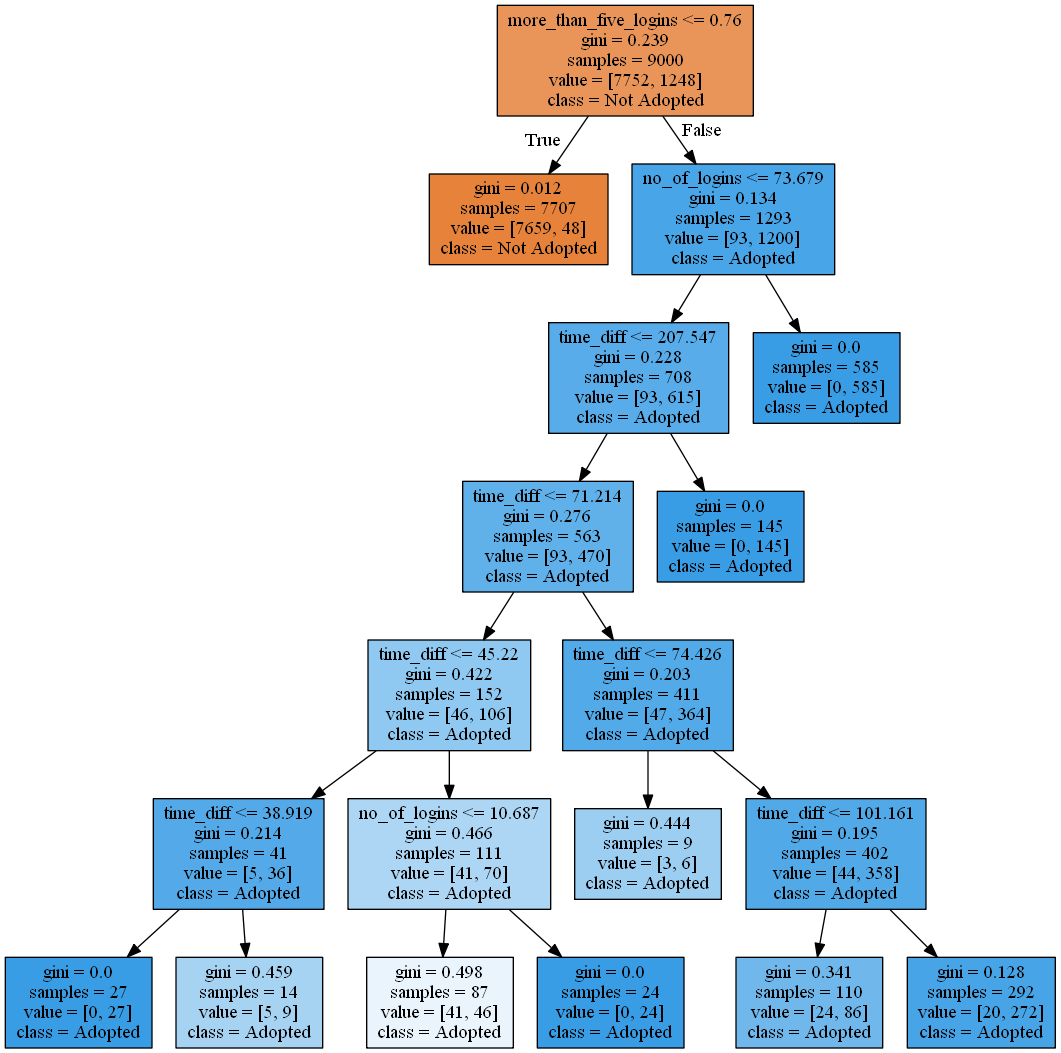

In [749]:
#Displaying the decision tree
from sklearn import tree
#from StringIO import StringIO
from io import StringIO
#from StringIO import StringIO 
from IPython.display import Image
out = StringIO()
tree.export_graphviz(classifier, feature_names = X.columns,out_file=out, filled=True, class_names = ['Not Adopted','Adopted'])
import pydotplus
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

The decision tree tells us that the most important factor is whether the user has logged in five or more times.  If they have, there's a good possiblity they will adopt the service.  Another strong indicator is the time between signup and the latest login.  Those who have hung on to the service the longest have obviously adopted and use the service often.

In [750]:
from sklearn.ensemble import GradientBoostingClassifier

#X = users.drop(['object_id','creation_time','name', 'email', 'creation_source','last_session_creation_time','adopted','invited_by_user_id'], axis = 1)
#y = users.adopted

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = GradientBoostingClassifier(verbose=True, n_estimators=200)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.6304            1.19s
         2           0.5329            1.19s
         3           0.4627            1.05s
         4           0.4079            1.03s
         5           0.3631            1.09s
         6           0.3258            1.04s
         7           0.2939            1.04s
         8           0.2665            1.01s
         9           0.2427            0.99s
        10           0.2220            0.95s
        20           0.1064            0.84s
        30           0.0669            0.73s
        40           0.0517            0.64s
        50           0.0448            0.57s
        60           0.0407            0.52s
        70           0.0382            0.49s
        80           0.0359            0.45s
        90           0.0334            0.42s
       100           0.0316            0.37s
       200           0.0198            0.00s


0.98166666666666669

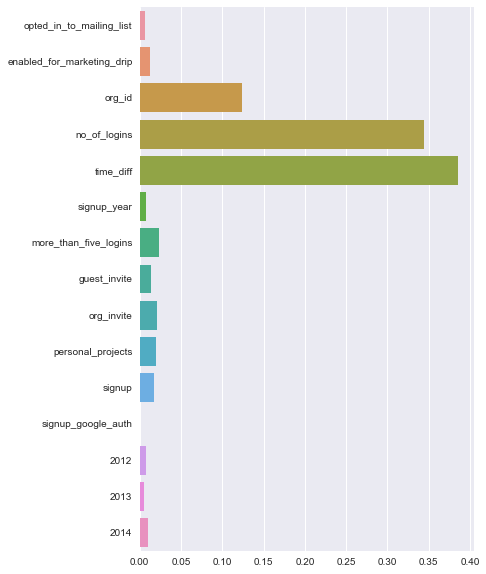

In [751]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns,  x=classifier.feature_importances_)
plt.show()

This second model shows us more of what we already know.  The time difference and number of logins is important.  What's new is that it seems that the organization a user belongs to has an impact on whether they adopt the service. 